In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential

from layers import FFDense
from models import FFNetwork
import utils


c:\Users\karen\myprojects\forward-forward\fwd-fwd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Feature extractor

Pretrained CNN (mobilenet)

In [2]:
module_selection = ('mobilenet_v2', 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)

extract_layer = hub.KerasLayer(MODULE_HANDLE,
                              input_shape=IMAGE_SIZE + (3,), 
                              output_shape=[FV_SIZE],
                              trainable=False)
     
extractor = Sequential([extract_layer])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Forward-Forward classifier

In [3]:
class ImageClassifier:
    def __init__(self, extractor, layers, learning_rate=0.03):
        self.extractor = extractor
        inner_dim = self.extractor.output.shape[1]
        self.layer_list = [Input(shape=(inner_dim,))]
        for dim in layers:
            self.layer_list += [
                FFDense(dim, activation='relu')
            ]
        
        self.learning_rate = learning_rate

    def FF_fit(self, x, y):
        pass

    def fit(self, x_batches):
        for image_batch, label_batch in x_batches:
            latent_imgs = extractor.predict(image_batch)
    
    def predict(self, x_batches):
        pass

## Collect data

In [4]:
class_names= ['cat', 'dog']

(raw_train, raw_test), metadata = tfds.load('cats_vs_dogs',
                                            split=['train[:80%]', 'train[90%:]'],
                                            with_info=True,
                                            as_supervised=True)

def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return image, label

num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE)
test_batches = raw_test.map(format_image).batch(BATCH_SIZE)

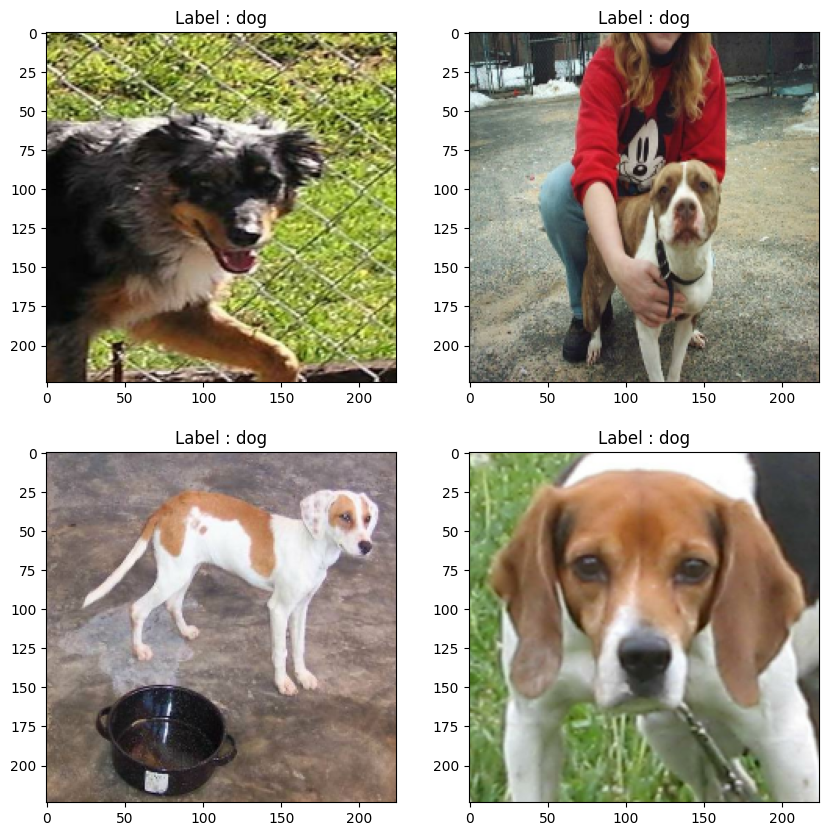

In [5]:
ds = raw_train.take(100)
imgs = []
labels = []
for image, label in tfds.as_numpy(ds):
  image = tf.image.resize(image, (224, 224)) / 255.0
  imgs.append(image)
  labels.append(label)
imgs = np.array(imgs)
labels = np.array(labels)

utils.show_samples(imgs, labels, 4, class_names)